Missing Values:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Incorrect Entries (Negative Values in Columns where only Positive Expected):
GHI: 258847 rows with negative values
DNI: 275987 rows with negative values
DHI: 259182 rows with negative values
WS: 0 rows with negative values
WSgust: 0 rows with negative values
ModA: 0 rows with negative values
ModB: 0 rows with negative values


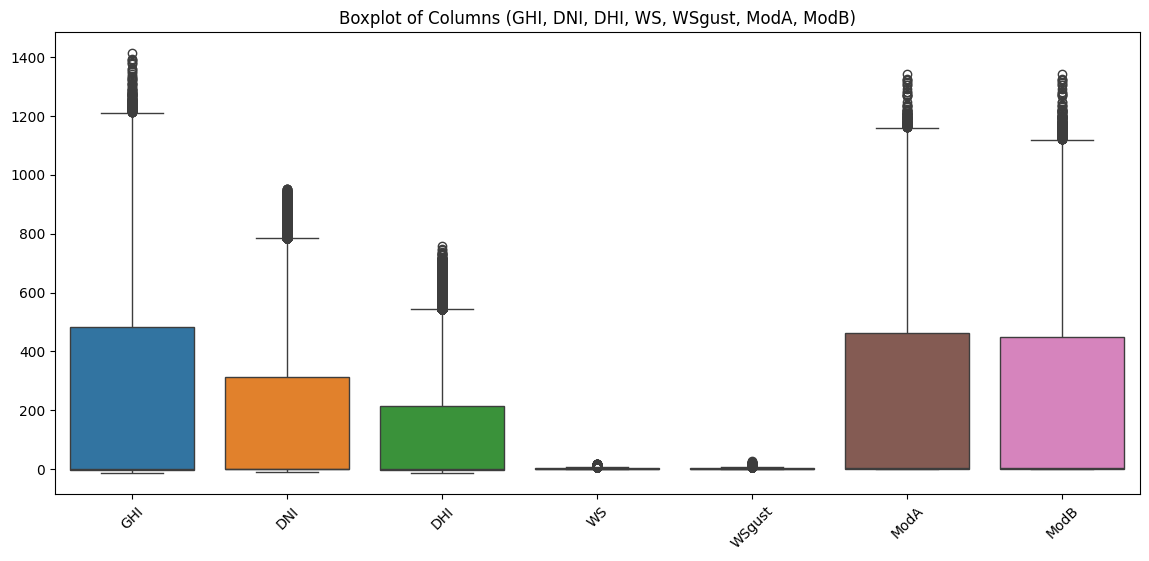

<Figure size 1400x800 with 0 Axes>

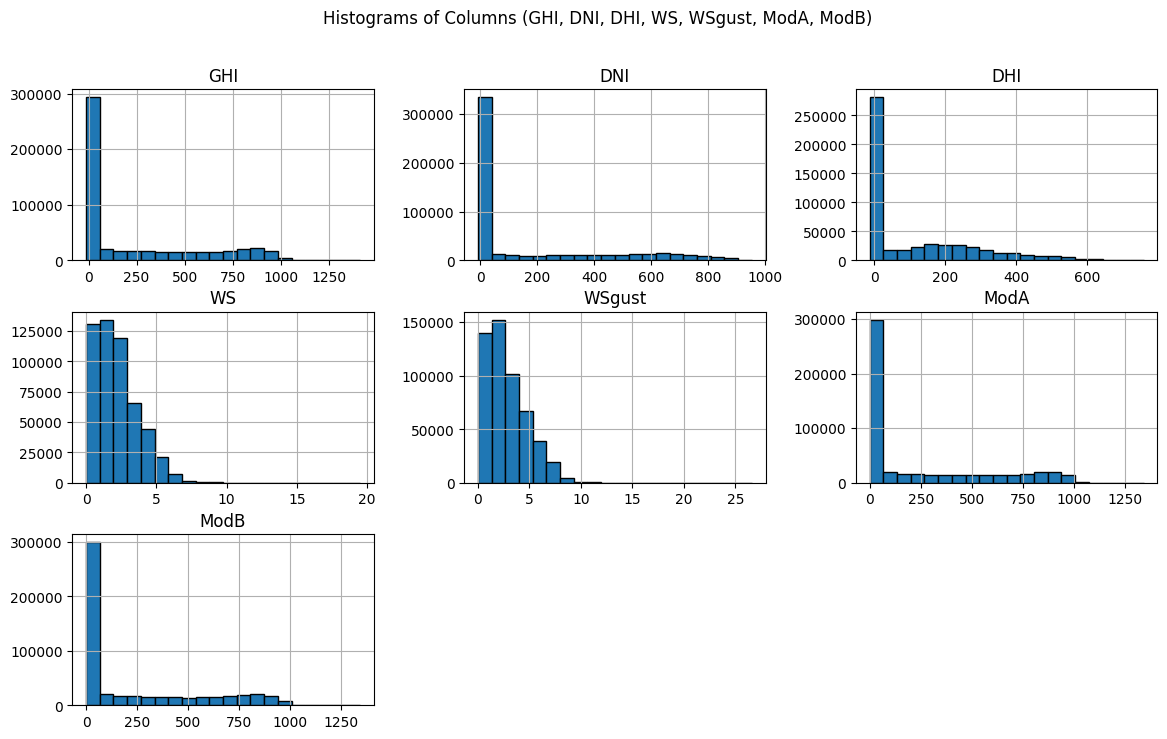

In [ ]:
# data quality check 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def data_quality_check(df):
    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing Values:\n", missing_values)

    # Check for incorrect entries (e.g., negative values in columns where only positives should exist)
    columns_to_check = ['GHI', 'DNI', 'DHI', 'WS', 'WSgust', 'ModA', 'ModB']
    
    # Identify negative values in the columns where only positive values should exist
    incorrect_entries = {}
    for column in columns_to_check:
        incorrect_entries[column] = df[df[column] < 0][column].count()
        
    print("\nIncorrect Entries (Negative Values in Columns where only Positive Expected):")
    for column, count in incorrect_entries.items():
        print(f"{column}: {count} rows with negative values")
    
    # Boxplot visualization of potential outliers for sensor readings and wind data
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df[columns_to_check])
    plt.title("Boxplot of Columns (GHI, DNI, DHI, WS, WSgust, ModA, ModB)")
    plt.xticks(rotation=45)
    plt.show()
        
    # Visualize Distribution with Histograms for better understanding
    plt.figure(figsize=(14, 8))
    df[columns_to_check].hist(bins=20, edgecolor='black', figsize=(14, 8))
    plt.suptitle('Histograms of Columns (GHI, DNI, DHI, WS, WSgust, ModA, ModB)')
    plt.show()

# Example Usage
if __name__ == "__main__":
    df = pd.read_csv('../assets/data/benin-malanville.csv')
    
    # Perform Data Quality Check
    data_quality_check(df)


In [1]:
# summary statistics

import pandas as pd
import numpy as np

def clean_data(df):
    # Convert 'date' column to datetime if it exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Fill missing values with the median for numeric columns to handle missing values 
    df = df.fillna(df.median(numeric_only=True))

    # Columns to check for invalid (negative) values
    columns_to_check = ['GHI', 'DNI', 'DHI', 'WS', 'WSgust', 'ModA', 'ModB']
    
    # Replace negative values in these columns with NaN
    for column in columns_to_check:
        if column in df.columns: 
            df[column] = df[column].apply(lambda x: x if pd.notnull(x) and x >= 0 else np.nan)

    # Drop irrelevant or problematic columns
    df = df.drop(columns=['Timestamp'], errors='ignore')  # Safely drop if 'Timestamp' exists

    # Select only numeric columns for further analysis
    df_numeric = df.select_dtypes(include=['float64', 'int64'])

    return df, df_numeric

def calculate_summary_statistics(df_numeric):
    
    # Calculate basic statistics using describe()
    summary_stats = df_numeric.describe().T  # Transpose for better readability
    
    # Add additional statistics
    summary_stats['median'] = df_numeric.median()  # Median
    summary_stats['variance'] = df_numeric.var()  # Variance
    summary_stats['skewness'] = df_numeric.skew()  # Skewness
    summary_stats['kurtosis'] = df_numeric.kurt()  # Kurtosis

    return summary_stats

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file '../assets/data/benin-malanville.csv' was not found.")
        exit()

    # Clean the data
    df_cleaned, df_numeric = clean_data(df)

    # Check if numeric columns are present
    if not df_numeric.empty:
        # Calculate and display the summary statistics
        summary = calculate_summary_statistics(df_numeric)
        print(summary)

        # Optionally, save the summary statistics to a file
        summary.to_csv('../assets/EDA-result/summary_statistics_benin.csv', index=True)
    else:
        print("No numeric columns found in the dataset for statistical analysis.")


                  count        mean         std    min    25%    50%    75%  \
GHI            266753.0  476.746489  320.578541    0.0  176.9  474.2  771.9   
DNI            249613.0  352.575567  280.657284    0.0   54.1  345.7  602.9   
DHI            266418.0  230.808498  150.487752    0.0  117.9  213.4  324.2   
ModA           525600.0  236.589496  326.894859    0.0    0.0    4.5  463.7   
ModB           525600.0  228.883576  316.536515    0.0    0.0    4.3  447.9   
Tamb           525600.0   28.179683    5.924297   11.0   24.2   28.0   32.3   
RH             525600.0   54.487969   28.073069    2.1   28.8   55.1   80.1   
WS             525600.0    2.121113    1.603466    0.0    1.0    1.9    3.1   
WSgust         525600.0    2.809195    2.029120    0.0    1.3    2.6    4.1   
WSstdev        525600.0    0.473390    0.273395    0.0    0.4    0.5    0.6   
WD             525600.0  153.435172  102.332842    0.0   59.0  181.0  235.1   
WDstdev        525600.0    8.582407    6.385864    0

In [ ]:
# time series 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_time_series(df):
        
    # Ensure 'Timestamp' column is in datetime format
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    else:
        raise KeyError("The DataFrame must contain a 'Timestamp' column.")
    
    # Extract useful time-based features
    df['date'] = df['Timestamp'].dt.date  # Extract date
    df['month'] = df['Timestamp'].dt.month  # Extract month
    df['hour'] = df['Timestamp'].dt.hour  # Extract hour

    return df


# Plots time series data for the specified columns grouped by a time-based feature.
def plot_time_series(df, group_by, columns, plot_type="line"):
    # Group data by the specified feature and calculate mean
    grouped = df.groupby(group_by)[columns].mean()

    # Create subplots for each column
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns), sharex=True)

    for i, column in enumerate(columns):
        ax = axes[i] if num_columns > 1 else axes
        if plot_type == "line":
            grouped[column].plot(ax=ax, kind="line", marker='o', title=f"{column} over {group_by.capitalize()}")
        elif plot_type == "bar":
            grouped[column].plot(ax=ax, kind="bar", title=f"{column} over {group_by.capitalize()}")
        ax.set_ylabel(column)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Main script for execution
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file '../assets/data/benin-malanville.csv' was not found.")
        exit()

    # Preprocess the data for time series analysis
    try:
        df = preprocess_time_series(df)
    except KeyError as e:
        print(e)
        exit()

    # Ensure the features are added correctly
    print("Columns after preprocessing:", df.columns)
    print(df[['Timestamp', 'date', 'month', 'hour']].head())

    # Columns to analyze
    columns_to_analyze = ['GHI', 'DNI', 'DHI', 'Tamb']

    # Filter columns to ensure they exist in the dataset
    columns_to_analyze = [col for col in columns_to_analyze if col in df.columns]

    if not columns_to_analyze:
        print("No columns available for analysis.")
        exit()

    # Plot line charts grouped by month
    print("Plotting trends by month:")
    plot_time_series(df, group_by="month", columns=columns_to_analyze, plot_type="line")

    # Plot bar charts grouped by hour of the day
    print("Plotting trends by hour of the day:")
    plot_time_series(df, group_by="hour", columns=columns_to_analyze, plot_type="bar")


In [ ]:
# cleaning impact 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluates the impact of cleaning on sensor readings.
def evaluate_cleaning_impact(df, cleaning_col='Cleaning', sensors=['ModA', 'ModB'], timestamp_col='Timestamp'):
    # Ensure timestamp is in datetime format
    if timestamp_col in df.columns:
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    else:
        raise KeyError(f"The DataFrame must contain a '{timestamp_col}' column.")

    if cleaning_col not in df.columns:
        raise KeyError(f"The DataFrame must contain a '{cleaning_col}' column.")
    
    # Filter data with valid timestamps and sort by timestamp
    df = df.dropna(subset=[timestamp_col]).sort_values(by=timestamp_col)
    
    # Separate data before and after cleaning events
    df['Cleaning_Event'] = (df[cleaning_col] == 1).astype(int)
    df['Cleaning_Cumulative'] = df['Cleaning_Event'].cumsum()  # Cumulative count of cleaning events

    # Group data by cleaning events
    grouped = df.groupby('Cleaning_Cumulative')[sensors].mean()

    # Plot sensor readings before and after cleaning events
    fig, axes = plt.subplots(len(sensors), 1, figsize=(12, 6 * len(sensors)), sharex=True)
    for i, sensor in enumerate(sensors):
        ax = axes[i] if len(sensors) > 1 else axes
        sns.lineplot(data=df, x=timestamp_col, y=sensor, hue='Cleaning_Cumulative', ax=ax)
        ax.set_title(f"Impact of Cleaning on {sensor}")
        ax.set_ylabel(sensor)
        ax.set_xlabel("Timestamp")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Summary statistics by cleaning group
    print("\nSummary Statistics of Sensor Readings by Cleaning Events:")
    print(grouped)

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file '../assets/data/benin-malanville.csv' was not found.")
        exit()

    # Evaluate the impact of cleaning on ModA and ModB
    try:
        evaluate_cleaning_impact(df, cleaning_col='Cleaning', sensors=['ModA', 'ModB'], timestamp_col='Timestamp')
    except KeyError as e:
        print(e)
        exit()


In [ ]:
# correlation analysis 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Performs correlation analysis on solar radiation, temperature, and wind conditions.
def correlation_analysis(df, radiation_cols=['GHI', 'DNI', 'DHI'], temperature_cols=['TModA', 'TModB'], wind_cols=['WS', 'WSgust', 'WD']):

    # Check if columns exist in the DataFrame
    all_columns = radiation_cols + temperature_cols + wind_cols
    missing_columns = [col for col in all_columns if col not in df.columns]

    if missing_columns:
        print(f"Warning: The following columns are missing: {missing_columns}")
    
    #  Correlation Matrix for Solar Radiation and Temperature
    correlation_data = df[radiation_cols + temperature_cols].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title("Correlation Matrix: Solar Radiation and Temperature")
    plt.show()

    #  Pair Plot for Solar Radiation and Temperature
    plt.figure(figsize=(10, 8))
    sns.pairplot(df[radiation_cols + temperature_cols], kind='scatter', diag_kind='kde', markers='o')
    plt.suptitle("Pair Plot: Solar Radiation and Temperature", y=1.02)
    plt.show()

    # Scatter Matrix for Wind Conditions vs. Solar Irradiance
    wind_radiation_data = df[wind_cols + radiation_cols]
    
    # Plot the scatter matrix
    sns.pairplot(wind_radiation_data, kind='scatter', diag_kind='kde', markers='o', hue=None)
    plt.suptitle("Scatter Matrix: Wind Conditions and Solar Irradiance", y=1.02)
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Perform the correlation analysis
    correlation_analysis(df)


In [ ]:
# wind analysis 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from windrose import WindroseAxes

# Plots a wind rose showing the distribution of wind speed and direction.
def plot_wind_rose(df, wind_speed_col='WS', wind_direction_col='WD'):
    
    # Ensure wind speed and direction columns exist
    if wind_speed_col not in df.columns or wind_direction_col not in df.columns:
        raise KeyError(f"The DataFrame must contain columns '{wind_speed_col}' and '{wind_direction_col}'.")

    # Prepare data for the wind rose plot
    wind_speed = df[wind_speed_col].dropna()
    wind_direction = df[wind_direction_col].dropna()

    # Initialize the wind rose axes
    ax = WindroseAxes.from_ax()

    # Create the wind rose plot
    ax.bar(wind_direction, wind_speed, bins=np.arange(0, 360, 45), normed=True, opening=0.8, edgecolor='black')

    # Customize the plot
    ax.set_title("Wind Rose - Wind Speed and Direction Distribution")
    ax.set_legend(title="Wind Speed (m/s)")

    plt.show()


# Creates a radial bar plot showing the distribution of wind speed and direction.
def plot_radial_bar(df, wind_speed_col='WS', wind_direction_col='WD'):
    # Ensure the columns exist in the DataFrame
    if wind_speed_col not in df.columns or wind_direction_col not in df.columns:
        raise KeyError(f"The DataFrame must contain columns '{wind_speed_col}' and '{wind_direction_col}'.")

    # Prepare wind speed and direction data, dropping rows where either is missing
    df_clean = df.dropna(subset=[wind_speed_col, wind_direction_col])

    # Ensure there is data after cleaning
    if df_clean.empty:
        raise ValueError("No valid data available for plotting.")

    wind_speed = df_clean[wind_speed_col]
    wind_direction = df_clean[wind_direction_col]

    # Convert wind direction to radians
    wind_direction_rad = np.deg2rad(wind_direction)

    # Create a radial bar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

    # Plot data as bars on the polar plot (wind speed vs. wind direction)
    ax.bar(wind_direction_rad, wind_speed, width=0.3, edgecolor='black', alpha=0.7)

    # Customize the plot
    ax.set_title("Radial Bar Plot: Wind Speed and Direction")
    ax.set_xlabel("Wind Direction")
    ax.set_ylabel("Wind Speed (m/s)")

    # Show plot
    plt.show()



# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Plot Wind Rose
    plot_wind_rose(df, wind_speed_col='WS', wind_direction_col='WD')

    # Plot Radial Bar Plot
    plot_radial_bar(df, wind_speed_col='WS', wind_direction_col='WD')



In [ ]:
# temperature analysis 


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plots a scatter plot to visualize the relationship between two variables.
def plot_scatter(df, x_col, y_col, title, xlabel, ylabel):
   
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.6, edgecolors='w', s=100)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

#  Plots a pairplot to analyze the relationships and correlations between variables.
def plot_pairplot(df, columns, title="Correlation Analysis"):
    
    sns.pairplot(df[columns], height=2.5)
    plt.suptitle(title, y=1.02)
    plt.show()


    # Calculates and visualizes the correlation matrix for selected columns.
def correlation_matrix(df, columns):
    
    corr_matrix = df[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Check if required columns are present in the DataFrame
    required_columns = ['RH', 'TModA', 'TModB', 'GHI', 'DNI', 'DHI']
    if not all(col in df.columns for col in required_columns):
        print("Error: Missing one or more required columns.")
        exit()

    # 1. Scatter plot: Temperature vs. Relative Humidity (TModA vs RH)
    plot_scatter(df, 'RH', 'TModA', 'Temperature vs. Relative Humidity (TModA)', 'Relative Humidity (%)', 'Temperature (°C)')

    # 2. Scatter plot: Solar Radiation vs. Relative Humidity (GHI vs RH)
    plot_scatter(df, 'RH', 'GHI', 'Solar Radiation vs. Relative Humidity (GHI)', 'Relative Humidity (%)', 'Global Horizontal Irradiance (W/m²)')

    # 3. Pairplot to visualize correlations between RH, TModA, TModB, GHI, DNI, DHI
    plot_pairplot(df, ['RH', 'TModA', 'TModB', 'GHI', 'DNI', 'DHI'], "Temperature and Solar Radiation Analysis")

    # 4. Correlation Matrix: RH, TModA, TModB, GHI, DNI, DHI
    correlation_matrix(df, ['RH', 'TModA', 'TModB', 'GHI', 'DNI', 'DHI'])


In [ ]:
# histograms 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#  Plots histograms for the specified columns to visualize their frequency distribution.
def plot_histograms(df, columns, bins=20, title="Histogram Analysis"):
    
    # Create subplots for each column
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))
    
    if num_columns == 1:
        axes = [axes]  # Make sure axes is iterable if only one column

    for i, column in enumerate(columns):
        ax = axes[i]
        sns.histplot(df[column], bins=bins, kde=True, ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'{column} Distribution')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Check if required columns are present in the DataFrame
    required_columns = ['GHI', 'DNI', 'DHI', 'WS', 'TModA', 'TModB']
    if not all(col in df.columns for col in required_columns):
        print("Error: Missing one or more required columns.")
        exit()

    # List of columns to analyze for histograms
    columns_to_analyze = ['GHI', 'DNI', 'DHI', 'WS', 'TModA', 'TModB']

    # Plot histograms for the specified columns
    plot_histograms(df, columns_to_analyze, bins=20, title="Distribution of Solar and Temperature Variables")




In [ ]:
# z score analysis 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Calculate Z-scores for the specified columns in the DataFrame.
def calculate_z_scores(df, columns):
    
    df_z_scores = df[columns].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    return df_z_scores


# Flag data points where the absolute Z-score exceeds the specified threshold.
def flag_outliers(df_z_scores, threshold=3):
   
    df_outliers = df_z_scores.abs() > threshold
    return df_outliers

#  Plot histograms of Z-scores to visualize the distribution and outliers.
def plot_z_scores(df_z_scores, columns):
    
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))
    
    if num_columns == 1:
        axes = [axes]  # Make sure axes is iterable if only one column

    for i, column in enumerate(columns):
        ax = axes[i]
        df_z_scores[column].plot(kind="hist", bins=30, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'{column} Z-Score Distribution')
        ax.set_xlabel('Z-Score')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Check if required columns are present in the DataFrame
    required_columns = ['GHI', 'DNI', 'DHI', 'WS', 'TModA', 'TModB']
    if not all(col in df.columns for col in required_columns):
        print("Error: Missing one or more required columns.")
        exit()

    # List of columns to analyze for Z-scores
    columns_to_analyze = ['GHI', 'DNI', 'DHI', 'WS', 'TModA', 'TModB']

    # Calculate Z-scores for the specified columns
    df_z_scores = calculate_z_scores(df, columns_to_analyze)

    # Flag outliers based on Z-score threshold (default is 3)
    df_outliers = flag_outliers(df_z_scores, threshold=3)

    # Display the flagged outliers
    print("Flagged Outliers (True indicates outlier):")
    print(df_outliers)

    # Plot histograms of Z-scores to visualize the distribution
    plot_z_scores(df_z_scores, columns_to_analyze)


In [ ]:
#  bubble charts 

import pandas as pd
import matplotlib.pyplot as plt


# Plots a bubble chart for the given columns in the DataFrame.
def plot_bubble_chart(df, x_column, y_column, size_column, color_column=None, title="Bubble Chart"):

    # Ensure the required columns are present
    required_columns = [x_column, y_column, size_column]
    if not all(col in df.columns for col in required_columns):
        print(f"Error: Missing one or more required columns: {required_columns}")
        return

    # Define the bubble size (we can scale the size for better visibility)
    size = df[size_column] * 10  # Scale the size for visibility, you can adjust the factor as needed
    if color_column and color_column in df.columns:
        color = df[color_column]
    else:
        color = 'blue'  # Default to blue if no color column is provided

    # Create the bubble chart
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x=df[x_column], y=df[y_column], s=size, c=color, alpha=0.5, cmap='viridis', edgecolors="w", linewidth=0.5)
    
    # Add labels and title
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)

    # If a color column is specified, add a color bar
    if color_column:
        plt.colorbar(scatter, label=color_column)
    
    # Show the plot
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Check if required columns are present in the DataFrame
    required_columns = ['GHI', 'Tamb', 'WS', 'RH']  # Modify if using BP instead of RH
    if not all(col in df.columns for col in required_columns):
        print(f"Error: Missing one or more required columns: {required_columns}")
        exit()

    # Plot bubble chart with GHI vs Tamb vs WS, and RH as bubble size
    plot_bubble_chart(df, x_column='GHI', y_column='Tamb', size_column='RH', color_column='WS', title="GHI vs Tamb vs WS with RH as Bubble Size")


In [2]:
#  data cleaning 

import pandas as pd
import numpy as np


# Clean the dataset by handling missing values, anomalies, and irrelevant columns.
def clean_data(df):
    
    #  Drop columns that are entirely null (e.g., 'Comments')
    df = df.dropna(axis=1, how='all')  # Drop columns where all values are NaN
    
    #  Handle missing values in the remaining columns
    # Fill missing numerical columns with median, and categorical columns with mode
    for column in df.columns:
        if df[column].dtype == 'object':  # Categorical data
            df[column] = df[column].fillna(df[column].mode()[0])  # Fill with mode
        else:  # Numerical data
            df[column] = df[column].fillna(df[column].median())  # Fill with median
    
    # Handle anomalies in numerical columns (e.g., negative values where they shouldn't be)
    # Define the columns where you expect non-negative values
    columns_to_check = ['GHI', 'DNI', 'DHI', 'WS', 'WSgust', 'TModA', 'TModB']
    
    # Replace negative values in these columns with NaN (or you can choose to drop them if needed)
    for column in columns_to_check:
        if column in df.columns:
            df[column] = df[column].apply(lambda x: x if x >= 0 else np.nan)
    
    # Drop rows with NaN after anomaly correction (optional, depending on dataset size)
    df = df.dropna(how='any')  # Drop rows where any column has NaN (optional based on dataset size)
    
    return df

# Example Usage
if __name__ == "__main__":
    # Load dataset 
    try:
        df = pd.read_csv('../assets/data/benin-malanville.csv')
    except FileNotFoundError:
        print("Error: The file 'benin-malanville.csv' was not found.")
        exit()

    # Clean the data
    df_cleaned = clean_data(df)

    # Display the cleaned data (or save it to a new file)
    print(df_cleaned.head())

    # Optionally, save the cleaned dataset to a new file
    df_cleaned.to_csv('../assets/EDA-result/cleaned_benin_malanville.csv', index=False)


/tmp/ipykernel_60098/3685028194.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(df[column].mode()[0])  # Fill with mode
/tmp/ipykernel_60098/3685028194.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(df[column].median())  # Fill with median
/tmp/ipykernel_60098/3685028194.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

            Timestamp   GHI  DNI   DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
413  2021-08-09 06:54  16.7  0.0  16.5  16.1  16.3  24.2  98.8  0.0     0.0   
414  2021-08-09 06:55  18.2  0.1  18.0  17.4  17.6  24.2  98.8  0.0     0.0   
415  2021-08-09 06:56  19.7  0.3  19.5  18.7  18.9  24.2  98.8  0.0     0.0   
416  2021-08-09 06:57  21.1  0.6  20.9  19.9  20.1  24.2  98.9  0.0     0.0   
417  2021-08-09 06:58  22.5  1.1  22.2  21.1  21.3  24.2  98.9  0.0     0.0   

     WSstdev   WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  
413      0.0  0.0      0.0  997         0            0.0   24.2   23.7  
414      0.0  0.0      0.0  997         0            0.0   24.3   23.8  
415      0.0  0.0      0.0  997         0            0.0   24.3   23.9  
416      0.0  0.0      0.0  997         0            0.0   24.4   23.9  
417      0.0  0.0      0.0  997         0            0.0   24.5   24.0  
